# 8.3 Lab: Decision Trees

## 8.3.4 Boosting 

Demonstrate boosting for the `Boston` data set from the `MASS` package. We will use the `statsmodels` library to load the R `data.frame` into a `pandas.core.frame.DataFrame` object.

The R code uses the `gbm` package Generalized Boosted Regression Models, which uses `distribution = "gaussian"` for regression models and `distribution = "bernoulli"` for classification models. 

We will use the `sklearn.ensemble` namespace and its associated classifers and regressors for [ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html). Emsemble methods combine the predictions of several other models to improve generalizability and robustness. 

Along with `GradientBoostingClassifier` and `GradientBoostingRegressor` found in sci-kit learn, there is another library called `XGBoost` for [eXtreme Gradient Boosting](https://xgboost.ai/). There is a R library called `xgboost`, too.

### Imports



In [16]:
from typing import List, Dict, Tuple, Sequence, Union
import sys

import statsmodels # root namespace for typing
import statsmodels.api as statsModels # alias to hide the extra api namespace

import numpy
import pandas 

import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import GridSearchCV

import xgboost

import matplotlib.pyplot as pyplot

### Data Acquisition

Note that the Boston data set is available in the `sklearn.datasets` namespace by using the `load_boston()` function. The below is an example of using the `statsmodels` library for loading R datasets. 


In [17]:
# download the R data set as a pandas DataFrame
bostonDataSet: statsmodels.datasets.utils.Dataset = statsModels.datasets.get_rdataset ("Boston", "MASS")

# print out the help information on the data set to get the column documentation
print (bostonDataSet.__doc__)

+--------+-----------------+
| Boston | R Documentation |
+--------+-----------------+

Housing Values in Suburbs of Boston
-----------------------------------

Description
~~~~~~~~~~~

The ``Boston`` data frame has 506 rows and 14 columns.

Usage
~~~~~

::

   Boston

Format
~~~~~~

This data frame contains the following columns:

``crim``
   per capita crime rate by town.

``zn``
   proportion of residential land zoned for lots over 25,000 sq.ft.

``indus``
   proportion of non-retail business acres per town.

``chas``
   Charles River dummy variable (= 1 if tract bounds river; 0
   otherwise).

``nox``
   nitrogen oxides concentration (parts per 10 million).

``rm``
   average number of rooms per dwelling.

``age``
   proportion of owner-occupied units built prior to 1940.

``dis``
   weighted mean of distances to five Boston employment centres.

``rad``
   index of accessibility to radial highways.

``tax``
   full-value property-tax rate per \\$10,000.

``ptratio``
   pupil-teache

In [18]:
# Get the pandas DataFrame, use copy so that we can re-run from this point 
# and recover the original data set (non-referenced).
bostonDataFrame: pandas.core.frame.DataFrame = bostonDataSet.data.copy ()

# preview the data
bostonDataFrame.head () 

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### Modeling

The first model will use the sci-kit learn `GradientBoostingRegressor`. The parameter `max_features` defaults to `auto` for `max_features = n_featuers`, which will consider all predictors at each split. The `n_estimators` will be used to match the book with fitting 5000 trees and `max_depth` will be set to 4 to match the `interaction_depth` used.

Note: The book indicates that the default learning rate for `gbm` is `shrinkage = 0.001`, but the documentation indicates that the default learning rate is `shrinkage = 0.1` which is the same default for the scikit-learn regressor. Setting the shrinkage to 0.001 to match the book results in R.

**R Code**
```R
library (MASS)
library (gbm)
set.seed (1)
train <- nrow(1:nrow(Boston), nrow(Boston)/2)
boston.test = Boston [-train, "medv"]
boost.boston = gbm (medv ~ ., data = Boston [train, ], distribution = "gaussian", n.trees = 5000, interaction.depth = 4, shrinkage = 0.001)
boost.boston
summary (boost.boston)
```

In [19]:
# slice the data frame into the X matrix and the y response vector 
X = bostonDataFrame.iloc [:, 0:-1]  # skip response variable in the last position
y = bostonDataFrame.loc [:, ["medv"]].to_numpy().ravel () # as vector

# set the seed for repeatable results
numpy.random.seed (5) # this seed has results that approximately mirror R results

# use the train test splitter to split randomly into data sets (50% each)
trainX, testX, trainy, testy = sklearn.model_selection.train_test_split (X, y, test_size = 0.50)

# instatiate an instance of the sklearn.ensemble.GradientBoostingRegressor
gradientBoostingModel = GradientBoostingRegressor (learning_rate = 0.001, n_estimators=5000, max_depth = 4) # default to R learning rate (alpha)
gradientBoostingModel = gradientBoostingModel.fit (X = trainX, y = trainy)
gradientBoostingModel # print out the call to see the default parameters used to fit


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.001, loss='ls',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=5000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
# print summary like in R
lossFunction = { "ls": "least squares regression", "lad": "least absolute deviation", "huber": "huber (combination of ls and lad)", "quantile": "quantile regression" }

print ("A gradient boosted model with " + lossFunction [gradientBoostingModel.loss] + " loss function.")
print ("There were {:d} predictors of which {:d} had non-zero influence.".format (gradientBoostingModel.n_features_, sum (gradientBoostingModel.feature_importances_ > 0)))


A gradient boosted model with least squares regression loss function.
There were 13 predictors of which 13 had non-zero influence.


In [21]:
# let's get the feature importance similar to the summary function 
featureImportanceIndex = numpy.where (gradientBoostingModel.feature_importances_ > 0)
featureImportance = pandas.DataFrame (list (zip (list (trainX.columns [featureImportanceIndex]), list (gradientBoostingModel.feature_importances_ [featureImportanceIndex]))), columns=["Feature Name", "Importance"]).sort_values (by = "Importance", ascending = False)
featureImportance.reset_index (drop = True, inplace = True)
featureImportance


,Feature Name,Importance
0,lstat,0.471242
1,rm,0.307156
2,dis,0.068221
3,crim,0.037939
4,ptratio,0.036004
5,nox,0.021222
6,tax,0.014590
7,age,0.013374
8,rad,0.011687
9,black,0.010277


We can plot the variable importance and partial dependence plots for the most important variables. 

**R Code**
```R
par (mfrow = c (1,2))
plot (boost.boston, i = "rm")
plot (boost.boston, i = "lstat")
```

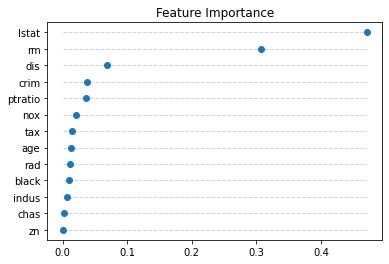

In [22]:
# combine the 2 arrays into a set of tuples of (importance, column-name) and sort
maxImportance = featureImportance ["Importance"].max ()

# resort again to get the right vertical placement
for index, currentRow in featureImportance.sort_values (by = "Importance", ascending = True).iterrows ():
    pyplot.plot ([0, maxImportance], [currentRow ["Feature Name"], currentRow ["Feature Name"]], linestyle = "--", linewidth = 1, color = "lightgray")

pyplot.scatter (x = featureImportance ["Importance"], 
                y = featureImportance ["Feature Name"], zorder=10)

ignore = pyplot.title ("Feature Importance")           

We can see from the feature importance that `lstat` and `rm` are by far the most important features in the gradient boosting.

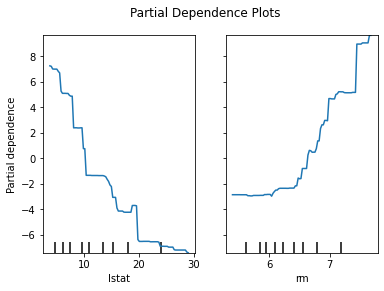

In [23]:
plot_partial_dependence (gradientBoostingModel, trainX, ["lstat", "rm"])
ignore = pyplot.suptitle ("Partial Dependence Plots")

### Predicting 

**R Code**
```R
# predict the original tree with a learning rate of 0.001
yhat.boost = predict (boost.boston, newdata = Boston [-train, ], n.trees = 5000)
mean ((yhat.boost - boston.test)^2)

# refitting with a learning rate of 0.2
boost.boston = gbm (medv ~ ., data = Boston [train, ], distribution = "gaussian", n.trees = 5000, interaction.depth = 4, shrinkage = 0.2, verbose = FALSE)
yhat.boost = predict (boost.boston, newdata = Boston [-train, ], n.trees = 5000)
mean ((yhat.boost - boston.test)^2)
```


In [24]:
# predict with the original learning rate (R rate of 0.001)
yhat = gradientBoostingModel.predict (X = testX)
mse = sklearn.metrics.mean_squared_error (testy, yhat)
print ("The test MSE for lambda = 0.001 is {:.4f}".format (mse))

# refitting for a learning rate of 0.2
gradientBoostingModel = GradientBoostingRegressor (learning_rate = 0.2, n_estimators=5000, max_depth=4)
gradientBoostingModel = gradientBoostingModel.fit (X = trainX, y = trainy)

# predict with the new learning rate
yhat = gradientBoostingModel.predict (X = testX)
mse = sklearn.metrics.mean_squared_error (testy, yhat)
print ("The test MSE for lambda = 0.2 is {:.4f}".format (mse))


The test MSE for lambda = 0.001 is 9.9466
The test MSE for lambda = 0.2 is 9.8952


### XGBoost

Now, we will build the XGBoost model using the same parameters. XGBoost supports different type of boosters: 

* `gbtree` - tree-based boosting 
* `dart` - tree-based boosting with drop-out (drop out trees to prevent overfitting)
* `gblinear` - linear based boosting

In [25]:
# hyperparameters = {
#     "booster": "gbtree", # tree-based boosting 
#     "verbosity": 3,      # 0 (silent), 1 (warning), 2 (info), 3 (debug)
#     # "num_features" - set automatically by XHBoost, feature dimension used in boosting
#     "eta": 0.001, # learning rate, default is 0.3
#     "max_depth": 6 # maximum tree depth, default is 6
#  }

xgboostRegressorModel = XGBRegressor (max_depth = 4, learning_rate = 0.001, n_estimators = 5000, boosters = "gbtree").fit (trainX, trainy)

In [26]:
# let's get the feature importance similar to the summary function 
featureImportanceIndex = numpy.where (xgboostRegressorModel.feature_importances_ > 0)
featureImportance = pandas.DataFrame (list (zip (list (trainX.columns [featureImportanceIndex]), list (xgboostRegressorModel.feature_importances_ [featureImportanceIndex]))), columns=["Feature Name", "Importance"]).sort_values (by = "Importance", ascending = False)
featureImportance.reset_index (drop = True, inplace = True)
featureImportance


,Feature Name,Importance
0,lstat,0.493872
1,rm,0.262565
2,dis,0.050877
3,crim,0.042345
4,nox,0.038754
5,ptratio,0.023673
6,indus,0.020958
7,tax,0.019921
8,age,0.017028
9,black,0.012089


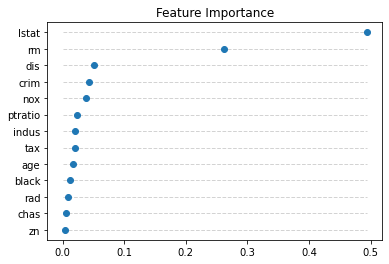

In [27]:
# combine the 2 arrays into a set of tuples of (importance, column-name) and sort
maxImportance = featureImportance ["Importance"].max ()

# resort again to get the right vertical placement
for index, currentRow in featureImportance.sort_values (by = "Importance", ascending = True).iterrows ():
    pyplot.plot ([0, maxImportance], [currentRow ["Feature Name"], currentRow ["Feature Name"]], linestyle = "--", linewidth = 1, color = "lightgray")

pyplot.scatter (x = featureImportance ["Importance"], 
                y = featureImportance ["Feature Name"], zorder=10)

ignore = pyplot.title ("Feature Importance")           

In [28]:
# predict with the original learning rate (R rate of 0.001)
yhat = xgboostRegressorModel.predict (testX)
mse = sklearn.metrics.mean_squared_error (testy, yhat)
print ("The test MSE for lambda = 0.001 is {:.4f}".format (mse))

# refitting for a learning rate of 0.2
xgboostRegressorModel = XGBRegressor (max_depth = 4, learning_rate = 0.2, n_estimators = 5000, boosters = "gbtree").fit (trainX, trainy)

# predict with the new learning rate
yhat = xgboostRegressorModel.predict (testX)
mse = sklearn.metrics.mean_squared_error (testy, yhat)
print ("The test MSE for lambda = 0.2 is {:.4f}".format (mse))

# refitting for defaults
xgboostRegressorModel = XGBRegressor (booster = "gbtree").fit (trainX, trainy)

# predict with the new learning rate
yhat = xgboostRegressorModel.predict (testX)
mse = sklearn.metrics.mean_squared_error (testy, yhat)
print ("The test MSE for defaults is {:.4f}".format (mse))


The test MSE for lambda = 0.001 is 10.8834
The test MSE for lambda = 0.2 is 10.4005
The test MSE for defaults is 11.5718


In [29]:
# grid search with cross-validation example on XGBoost 
xgboostRegressorModel = XGBRegressor ()

hyperparameters = {
     "eta": [0.001, 0.01, 0.10, 0.2, 1] , # learning_rate 
     "max_depth": [ 3, 4, 6, 8],  # tree depths
     "colsample_bytree": [0.3, 0.5, 1],  # % of predictors per split
     "n_estimators": [100, 500, 1000]
     }

grid = GridSearchCV(xgboostRegressorModel, hyperparameters, n_jobs=4).fit(trainX, trainy)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_est...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=4,
             param_grid={

In [30]:
xgboostRegressorModel = grid.best_estimator_
print ("Best parameters: ")
print (grid.best_params_)

# predict with the new learning rate
yhat = xgboostRegressorModel.predict (testX)
mse = sklearn.metrics.mean_squared_error (testy, yhat)
print ("The test MSE for best is {:.4f}".format (mse))

Best parameters: 
{'colsample_bytree': 0.3, 'eta': 0.2, 'max_depth': 3, 'n_estimators': 500}
The test MSE for best is 14.1464
